In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
vcf = "../../../data/HG002/variants/ConSTRain/v.0.8.1/HG002.GRCh38.2x250_with_mononuc.vcf" # str: path to input vcf file                      
vcf_format = "ConSTRain" # str: which tool was used to genotype
sample = "HG002.GRCh38.2x250" # str: name of sample in vcf to analyse
set_cn = False # bool: set CN of loci manually (based on chromosome name)
gt_in_bp = False # bool: does the tool report genotypes in bp (True) or in number of repeat units (False)
strs_covered_by_haplotypes = "../../../data/HG002/regions/hg38_ver13_0boe_mononucleotides_union.bed" # str: path to bed with loci that are covered by the haplotypes provided by Q100
haplotype_str_length = "../../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv" # str: path to csv with STR allele lengths based on Q100 haplotypes
comparison_file_out = None # None or str: path to write csv with comparison of STR allele lengths from vcf to Q100 STR allele lengths

depth_filter = 0.05 # None or float. Alpha to use for filtering loci with extreme depth values
filt_segdup = True

In [4]:
def set_cn_manually(df):
    autosomes = [f"chr{i}" for i in range(1, 23)]
    df = df.assign(
        copy_number = lambda x: [2 if i in autosomes else 1 for i in x["chr"]]
    )
    return df

In [5]:
df_repeats, df_hg002 = file_io.dfs_from_vcf(filename=vcf, samples=[sample], vcf_format=vcf_format)
df_hg002 = df_hg002.dropna().assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_norm = lambda x: x["depth"] / x["copy_number"]
).reset_index(drop=True)
df_hg002 = df_hg002.merge(df_repeats[["str_id", "period"]], on="str_id", how="left")
print(df_repeats.shape, df_hg002.shape)


(1733646, 7) (1691917, 8)


In [6]:
if depth_filter:
    print(df_hg002.shape)
    lower = df_hg002.query("period > 1")["depth_norm"].quantile(q=depth_filter/2)
    upper = df_hg002.query("period > 1")["depth_norm"].quantile(q=1-(depth_filter/2))
    print(lower, upper)
    df_hg002 = df_hg002.query(f"depth_norm >= {lower} and depth_norm <= {upper}").reset_index(drop=True)
    print(df_hg002.shape)


(1691917, 8)
12.0 44.5
(1464386, 8)


In [7]:
df_covered_repeats = pd.read_csv(strs_covered_by_haplotypes, sep="\t", names=["chr", "start", "end", "period", "unit"])
df_covered_repeats = df_covered_repeats.assign(
            str_id = np.array([f"{chrom}_{start + 1}" for chrom, start in zip(df_covered_repeats.chr, df_covered_repeats.start)])
)

df_covered_repeats = df_repeats[df_repeats["str_id"].isin(df_covered_repeats["str_id"])]

df_hg002 = df_hg002.merge(
    df_covered_repeats[["str_id", "chr", "start", "end", "unit", "ref"]], on="str_id", how="inner"
)

if set_cn:
    df_hg002 = set_cn_manually(df_hg002)
    
df_hg002 = df_hg002.dropna().reset_index(drop=True)

print(df_covered_repeats.shape, df_hg002.shape)

df_hg002


(1695865, 7) (1447310, 13)


,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,period,chr,start,end,unit,ref
0,HG002.GRCh38.2x250,chr1_590659,2,{3: 60},"[3, 3]",60,30.0,4,chr1,590659,590670,AAAT,3
1,HG002.GRCh38.2x250,chr1_590969,2,{4: 42},"[4, 4]",42,21.0,4,chr1,590969,590984,AAAC,4
2,HG002.GRCh38.2x250,chr1_597686,2,{14: 40},"[14, 14]",40,20.0,1,chr1,597686,597699,A,14
3,HG002.GRCh38.2x250,chr1_598935,2,{11: 37},"[11, 11]",37,18.5,1,chr1,598935,598945,G,11
4,HG002.GRCh38.2x250,chr1_599683,2,{5: 83},"[5, 5]",83,41.5,5,chr1,599683,599707,TTTTG,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447305,HG002.GRCh38.2x250,chrY_26625608,1,{2: 43},[2],43,43.0,7,chrY,26625608,26625621,TAAGTAT,2
1447306,HG002.GRCh38.2x250,chrY_26627699,1,{4: 23},[4],23,23.0,3,chrY,26627699,26627710,GAA,4
1447307,HG002.GRCh38.2x250,chrY_26628607,1,{3: 31},[3],31,31.0,5,chrY,26628607,26628621,ATTTT,3
1447308,HG002.GRCh38.2x250,chrY_26635262,1,{10: 33},[10],33,33.0,1,chrY,26635262,26635271,A,10


In [8]:
if filt_segdup:
    df_in_segdup = pd.read_csv("../../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
    df_in_segdup = df_in_segdup.assign(str_id = lambda x: [f"{i}_{j + 1}" for i, j in zip(x["chr"], x["start"])])
    
    df_hg002 = df_hg002[~df_hg002["str_id"].isin(df_in_segdup["str_id"])].reset_index(drop=True)
    print(df_hg002.shape)

(1393426, 13)


In [9]:
df_hg002.shape[0] / df_covered_repeats.shape[0] * 100

82.1660922302188

In [10]:
if gt_in_bp:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted(gt) for gt in x["genotype"]],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
else:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted([k * j for k in i]) for i, j in zip(x["genotype"], x["period"])],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
    
df_hg002

,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,period,chr,start,end,unit,ref,illumina_region_len
0,HG002.GRCh38.2x250,chr1_902774,2,"{13: 1, 14: 52, 15: 6}","[14, 14]",59,29.5,1,chr1,902774,902788,A,15,"[14, 14]"
1,HG002.GRCh38.2x250,chr1_904440,2,{3: 55},"[3, 3]",55,27.5,3,chr1,904440,904448,CTC,3,"[9, 9]"
2,HG002.GRCh38.2x250,chr1_904654,2,{4: 48},"[4, 4]",48,24.0,3,chr1,904654,904665,CCT,4,"[12, 12]"
3,HG002.GRCh38.2x250,chr1_907237,2,"{13: 1, 14: 48}","[14, 14]",49,24.5,1,chr1,907237,907250,A,14,"[14, 14]"
4,HG002.GRCh38.2x250,chr1_914949,2,{16: 35},"[16, 16]",35,17.5,1,chr1,914949,914964,A,16,"[16, 16]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393421,HG002.GRCh38.2x250,chrY_26487819,1,"{9: 2, 10: 29}",[10],31,31.0,1,chrY,26487819,26487828,A,10,[10]
1393422,HG002.GRCh38.2x250,chrY_26487987,1,{10: 38},[10],38,38.0,1,chrY,26487987,26487996,A,10,[10]
1393423,HG002.GRCh38.2x250,chrY_26489202,1,{3: 33},[3],33,33.0,4,chrY,26489202,26489213,TAAA,3,[12]
1393424,HG002.GRCh38.2x250,chrY_26489935,1,{4: 23},[4],23,23.0,3,chrY,26489935,26489946,AGA,4,[12]


In [11]:
df_strs_haplotypes = pd.read_csv(haplotype_str_length).assign(chr = lambda x: [i[0] for i in x["str_id"].str.split("_")])
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr
0,chr1_588068,12,12.0,12.0,chr1
1,chr1_589245,12,12.0,12.0,chr1
2,chr1_590659,12,12.0,12.0,chr1
3,chr1_590969,16,16.0,16.0,chr1
4,chr1_591734,18,20.0,20.0,chr1
...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY
1695861,chrY_57200838,14,NaN,15.0,chrY
1695862,chrY_57201000,20,NaN,20.0,chrY
1695863,chrY_57202381,23,NaN,23.0,chrY


In [12]:
autosomes = "chr != 'chrX' and chr != 'chrY'"
X = "chr == 'chrX'"
Y = "chr == 'chrY'"

df_strs_haplotypes["haplo_region_len"] = [[] for i in range(len(df_strs_haplotypes))]

df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "haplo_region_len"] = pd.Series([
    sorted([np.int64(i), np.int64(j)]) for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_mat"], 
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_pat"],)])

for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "region_len_mat"]):
    i.append(np.int64(j))
    
for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "region_len_pat"]):
    i.append(np.int64(j))
    
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr,haplo_region_len
0,chr1_588068,12,12.0,12.0,chr1,"[12, 12]"
1,chr1_589245,12,12.0,12.0,chr1,"[12, 12]"
2,chr1_590659,12,12.0,12.0,chr1,"[12, 12]"
3,chr1_590969,16,16.0,16.0,chr1,"[16, 16]"
4,chr1_591734,18,20.0,20.0,chr1,"[20, 20]"
...,...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY,[11]
1695861,chrY_57200838,14,NaN,15.0,chrY,[15]
1695862,chrY_57201000,20,NaN,20.0,chrY,[20]
1695863,chrY_57202381,23,NaN,23.0,chrY,[23]


In [13]:
df_comparison = (
    df_strs_haplotypes[["str_id", "haplo_region_len"]]
        .merge(df_hg002[["str_id", "illumina_region_len", "depth", "copy_number", "period"]], on="str_id", how="inner")
        .assign(
            match = lambda x: x["haplo_region_len"] == x["illumina_region_len"],
        )
)

df_comparison

,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
0,chr1_902774,"[14, 14]","[14, 14]",59,2,1,True
1,chr1_904440,"[9, 9]","[9, 9]",55,2,3,True
2,chr1_904654,"[12, 12]","[12, 12]",48,2,3,True
3,chr1_907237,"[14, 14]","[14, 14]",49,2,1,True
4,chr1_914949,"[16, 16]","[16, 16]",35,2,1,True
...,...,...,...,...,...,...,...
1393421,chrY_26487819,[10],[10],31,1,1,True
1393422,chrY_26487987,[10],[10],38,1,1,True
1393423,chrY_26489202,[12],[12],33,1,4,True
1393424,chrY_26489935,[12],[12],23,1,3,True


In [14]:
if comparison_file_out:
    df_comparison.to_csv(comparison_file_out, index=False)

In [15]:
n_wrong = df_comparison.loc[~df_comparison["match"]].shape[0]
n_total = df_comparison.shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

df_comparison.loc[~df_comparison["match"]]

n correct: 1369471, n wrong: 23955, n total: 1393426
Overall accuracy: 98.28085596221112


,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
13,chr1_937397,"[9, 11]","[9, 10]",29,2,1,False
59,chr1_1020848,"[13, 14]","[13, 13]",34,2,1,False
61,chr1_1035170,"[12, 12]","[12, 13]",31,2,1,False
80,chr1_1081643,"[11, 12]","[10, 10]",29,2,5,False
280,chr1_1540509,"[11, 12]","[11, 11]",55,2,1,False
...,...,...,...,...,...,...,...
1389356,chrX_155787824,[17],[16],17,1,1,False
1389357,chrX_155807410,[15],[16],44,1,1,False
1389558,chrY_6762460,[13],[12],13,1,2,False
1391163,chrY_14409113,[15],[16],21,1,1,False


In [31]:
total = 23955
out_of_phase = 4873
in_phase = total - out_of_phase

in_phase / total * 100

79.65769150490503

In [30]:
df_comparison.loc[~df_comparison["match"]].assign(
    out_of_phase = lambda x: [any([k % j != 0 for k in i]) for i, j in zip(x["haplo_region_len"], x["period"])]
).query("out_of_phase")

,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match,out_of_phase
80,chr1_1081643,"[11, 12]","[10, 10]",29,2,5,False,True
577,chr1_2098664,"[21, 30]","[30, 30]",27,2,5,False,True
824,chr1_2845231,"[35, 42]","[35, 35]",34,2,5,False,True
894,chr1_3088449,"[32, 43]","[32, 32]",27,2,4,False,True
1205,chr1_3941726,"[12, 13]","[12, 12]",38,2,2,False,True
...,...,...,...,...,...,...,...,...
1385323,chrX_145106895,[13],[12],40,1,4,False,True
1385772,chrX_146255548,[206],[21],21,1,7,False,True
1387387,chrX_150455763,[20],[18],17,1,3,False,True
1389176,chrX_155113110,[11],[12],12,1,4,False,True


In [16]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 7).reshape(-1, 1), np.tile([1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 1e6], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_comparison
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_comparison_filt = df_comparison.loc[df_comparison["str_id"].isin(selected_loci)]
    current_n = df_comparison_filt.shape[0]
    if current_n == 0:
        n.append(np.nan)
        accuracy.append(np.nan)
    else:
        n.append(current_n)
        accuracy.append((1 - (df_comparison_filt.loc[~df_comparison_filt["match"]].shape[0] / df_comparison_filt.shape[0])) * 100)

df_plot["n"] = n
df_plot["accuracy"] = accuracy
df_plot["depth"] = np.tile(["1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-"], 6)

In [17]:
for name, data in df_plot.groupby("depth"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())
print()
for name, data in df_plot.groupby("period"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())



1-5 nan 0.0
10-15 87.40150429799426 55840.0
15-20 93.12316421604943 114733.0
20-25 97.72220729336263 189789.0
25-30 99.24413138303612 324395.0
30- 99.71081206979859 691246.0
5-10 nan 0.0

1.0 nan 648217.0
2.0 nan 107602.0
3.0 nan 128182.0
4.0 nan 313372.0
5.0 nan 146736.0
6.0 nan 31894.0


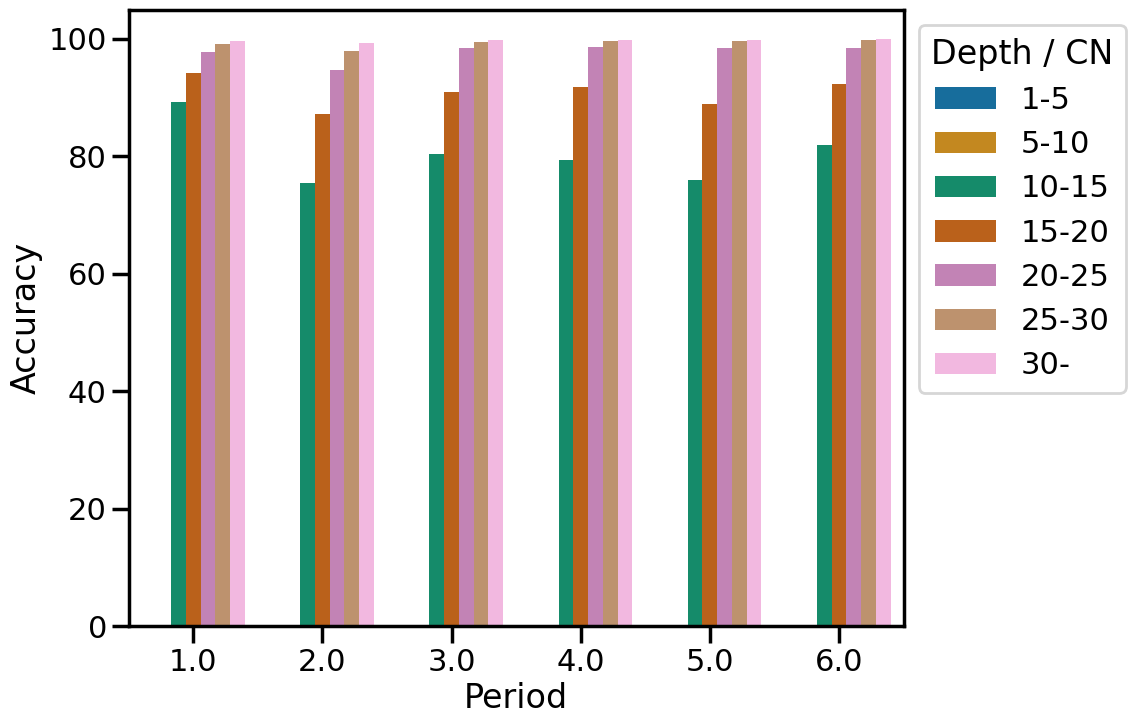

In [18]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    xlabel="Period",
    ylabel = "Accuracy"
)

_ = ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

In [19]:
from scipy import ndimage

df_plot_density = (
    df_comparison
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth = (
    df_plot_density        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth["accuracy"], 3, mode="reflect")
df_plot_smooth = df_plot_smooth.assign(smooth = smooth)


df_plot_smooth_period = (
    df_plot_density
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_smooth_period.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_smooth_period = df_plot_smooth_period.assign(smooth = np.concatenate(smooth))

df_plot_smooth_period

,period,depth,accuracy,n_obs,smooth
0,1,12.0,0.892515,7936,0.889988
1,1,12.5,0.867914,7427,0.891552
2,1,13.0,0.891706,8126,0.894564
3,1,13.5,0.889703,7643,0.898797
4,1,14.0,0.913891,8106,0.903952
...,...,...,...,...,...
391,6,42.5,1.000000,247,0.999160
392,6,43.0,0.995434,219,0.999210
393,6,43.5,1.000000,169,0.999269
394,6,44.0,1.000000,177,0.999326


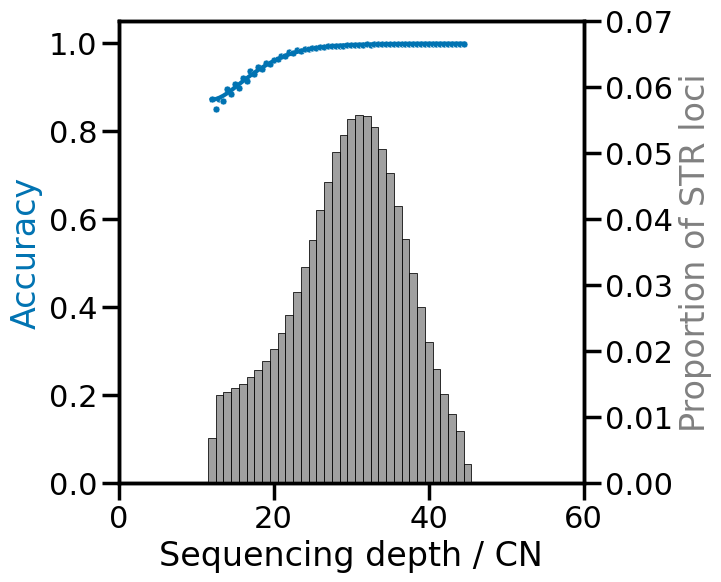

In [20]:
fig = plt.figure(figsize=(6, 6))

ax = sns.lineplot(
    df_plot_smooth.assign(tmp="ConSTRain"), # hack to add a legend
    x = "depth",
    y = "smooth",
    hue="tmp",
    palette="colorblind",
    legend=False
)

ax = sns.scatterplot(
    df_plot_smooth,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
)

ax.set(
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 60)
)
ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.07),
)
ax2.yaxis.label.set_color(color="grey")

plt.show()

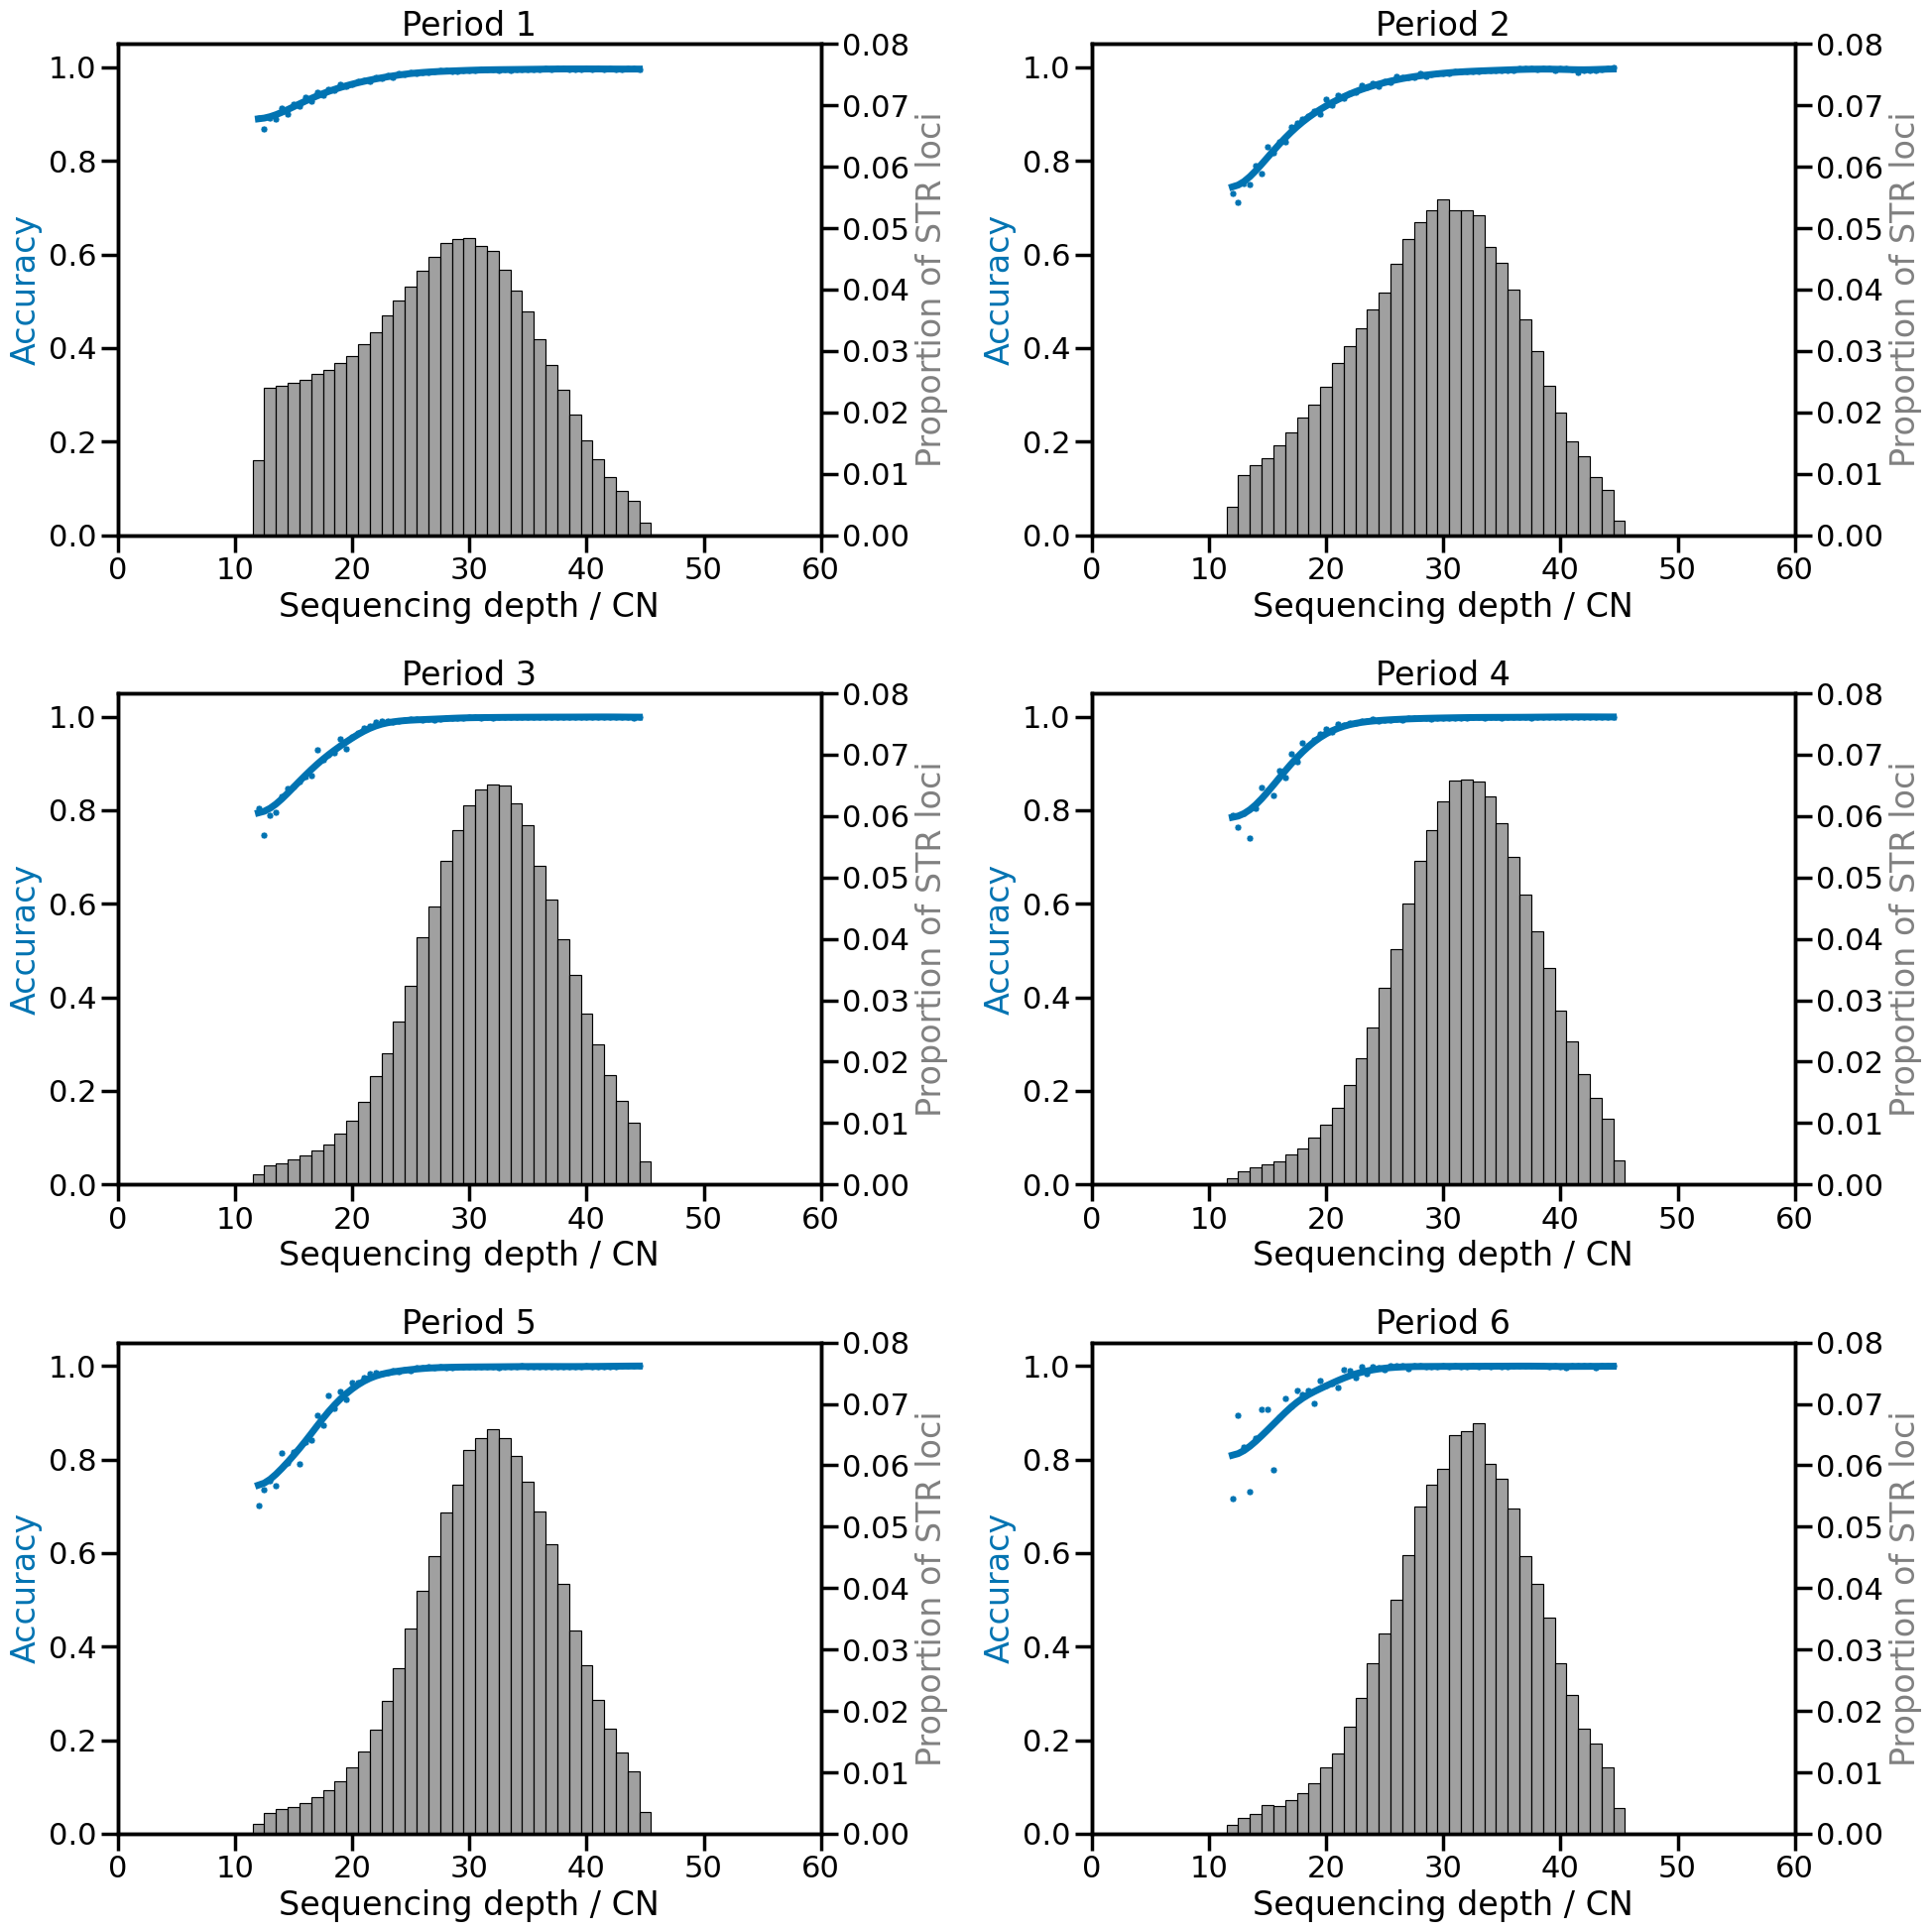

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot_smooth_period
                  .query(f"period == {period}"))

    ax = sns.lineplot(
        df_subplot,
        x = "depth",
        y = "smooth",
        color=sns.color_palette("colorblind")[0],
        linewidth=5,
        ax = ax,
    )

    ax = sns.scatterplot(
        df_subplot,
        x = "depth",
        y = "accuracy",
        color=sns.color_palette("colorblind")[0],
        s=25,
        ax = ax,
    )

    ax.set(
        title = f"Period {period}",
        xlabel = "Sequencing depth / CN",
        ylabel = "Accuracy",
        ylim = (0, 1.05),
        xlim = (0, 60)
    )
    ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])
    
    ax2 = ax.twinx()
    ax2 = sns.histplot(
        df_plot_density.query(f"period == {period}"),
        x = "depth",
        discrete=True,
        stat="proportion",
        color="grey",
        ax=ax2,
    )
    
    ax2.set(
        ylabel="Proportion of STR loci",
        ylim=(0, 0.08),
    )
    ax2.yaxis.label.set_color(color="grey")

plt.tight_layout()

In [22]:
df_plot_density_p1 = (
    df_comparison
        .query("period == 1")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth_p1 = (
    df_plot_density_p1        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth_p1["accuracy"], 3, mode="reflect")
df_plot_smooth_p1 = df_plot_smooth_p1.assign(smooth = smooth)

In [23]:
df_plot_density_pg1 = (
    df_comparison
        .query("period > 1")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth_pg1 = (
    df_plot_density_pg1        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth_pg1["accuracy"], 3, mode="reflect")
df_plot_smooth_pg1 = df_plot_smooth_pg1.assign(smooth = smooth)

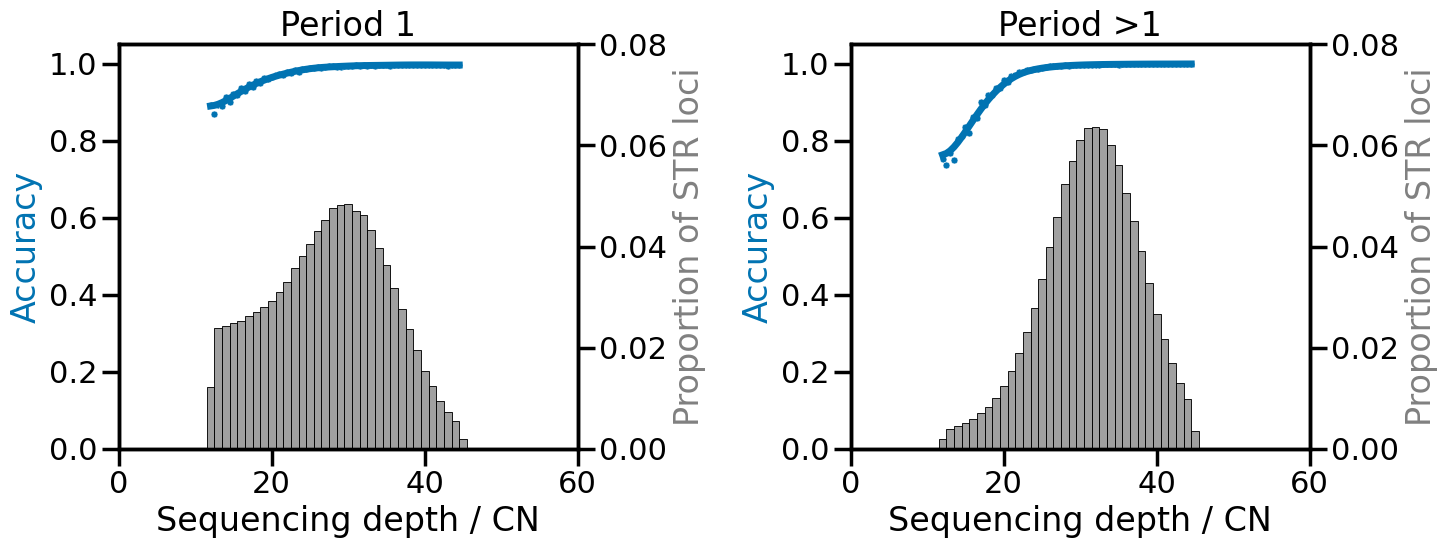

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = sns.lineplot(
    df_plot_smooth_p1,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    linewidth=5,
    ax = axes[0],
)

ax = sns.scatterplot(
    df_plot_smooth_p1,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
)

ax.set(
    title = "Period 1",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 60)
)
ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density_p1,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)

ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.08),
)
ax2.yaxis.label.set_color(color="grey")



ax = sns.lineplot(
    df_plot_smooth_pg1,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    linewidth=5,
    ax = axes[1],
)

ax = sns.scatterplot(
    df_plot_smooth_pg1,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
)

ax.set(
    title = "Period >1",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 60)
)
ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density_pg1,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)

ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.08),
)
ax2.yaxis.label.set_color(color="grey")

plt.tight_layout()